In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
#import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import networkx as nx
#from sympy.solvers import solve
#from sympy import Symbol

from scipy.optimize import fsolve
import pandas_datareader.data as web
import datetime
plt.rc('figure', figsize=(16, 10))
from numpy.linalg import inv
from numpy import dot
from IPython.display import Image

# FINM8006 Advanced Investment 
## Mean-Variance Maximization
---
Qiaoqiao Zhu   
Australian National University
_________

Review of Last Lecture
* SDF can be derived from state price or consumer/investor maximization or state-space projections. Risk-neutral Pricing is another version of the same problem. 
* Complete market and no arbitrage
* Many derivations from $p=E(mx)$: risk-free rate, excess return, beta representations etc

### Volatility Bounds
---------------------

Quantitative Properties of SDF
* SDF exists. It is unique when market is complete.
* SDF is not observable, which makes studying its quantitative property difficult.
* But we can use it's projections on payoff space to understand it quantitatively, let's start with the volatility bounds.

Let's recall
$$ 0=E_{t}[m_{t+1}R^{e}_{i}]=E(m)E(R^{e}_{i})+cov(m,R^{e}_{i})$$

$$ 0=E(m)E(R^{e}_{i})+\rho_{(m,R^{e}_{i})}\sigma_{R^{e}_{i}}\sigma_{m}$$
re-arrange, we get
$$\underset{\text{Sharpe Ratio}}{\frac{E(R_{i}-R_{f})}{\sigma_{R^{e}_{i}}}}=-\rho_{(m,R_{i})}\frac{\sigma_{m}}{E(m)}$$

$$ \frac{\sigma_{m}}{E(m)}=\frac{1}{-\rho} \frac{E(R_{i}-R_{f})}{\sigma_{R^{e}_{i}}} $$
$\rho$ is the correlation between $m$ and $R_{i}$, and $-\rho\leq 1 $
$$ \frac{\sigma_{m}}{E(m)}\geq \sup \left |\frac{E(R^{e}_{i})}{\sigma^{e}_{R_{i}}}\right| $$
equality only if $\rho_{mi}=-1$, $R_{i}$ perfectly negatively correlated with SDF, i.e., SDF is a *linear function* of the return. Sharpe ratio is at maximum when $\rho_{mi}=-1$. 

Minimum volatility bounds of SDF is maximum Sharpe ratio (of any portfolio).

$$\min \frac{\sigma_{m}}{E(m)} = \max\frac{E(R^{e}_{i})}{\sigma^{e}_{R_{i}}}$$



In [2]:
def efficfront(rf=0.01, dcml=1):
    er1 = 0.05
    er2 = 0.08
    s1 = 0.10
    s2 = 0.12
    rho = 0.2
    w = np.linspace(0,1, 50)
    er = w*er1+(1-w)*er2
    sigma = np.sqrt(w**2*s1**2+(1-w)**2*s2**2+2*w*(1-w)*rho*s1*s2)
    sr = (er-rf)/sigma
    maxsr = sr.max()
    x = np.linspace(0,0.16, 50)
    cml = rf + maxsr*x
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(sigma, er)
    plt.xlim(0, 0.15)
    plt.ylim(0, 0.1)
    plt.xlabel(r'$\sigma (R)$')
    plt.ylabel(r'$E(R)$')
    plt.title('Efficient Frontier')
    if dcml == 1:
        plt.plot(x, cml)
        plt.annotate(r'$\frac{1}{E(m)}$', (0, rf))
    if dcml == 2:
        rf2 = 0.02
        sr2 = (er-rf2)/sigma
        maxsr2 = sr2.max()
        cml2 = rf2 + maxsr2*x
        plt.plot(x, cml)
        plt.plot(x, cml2, linestyle='dashed')
    plt.show()

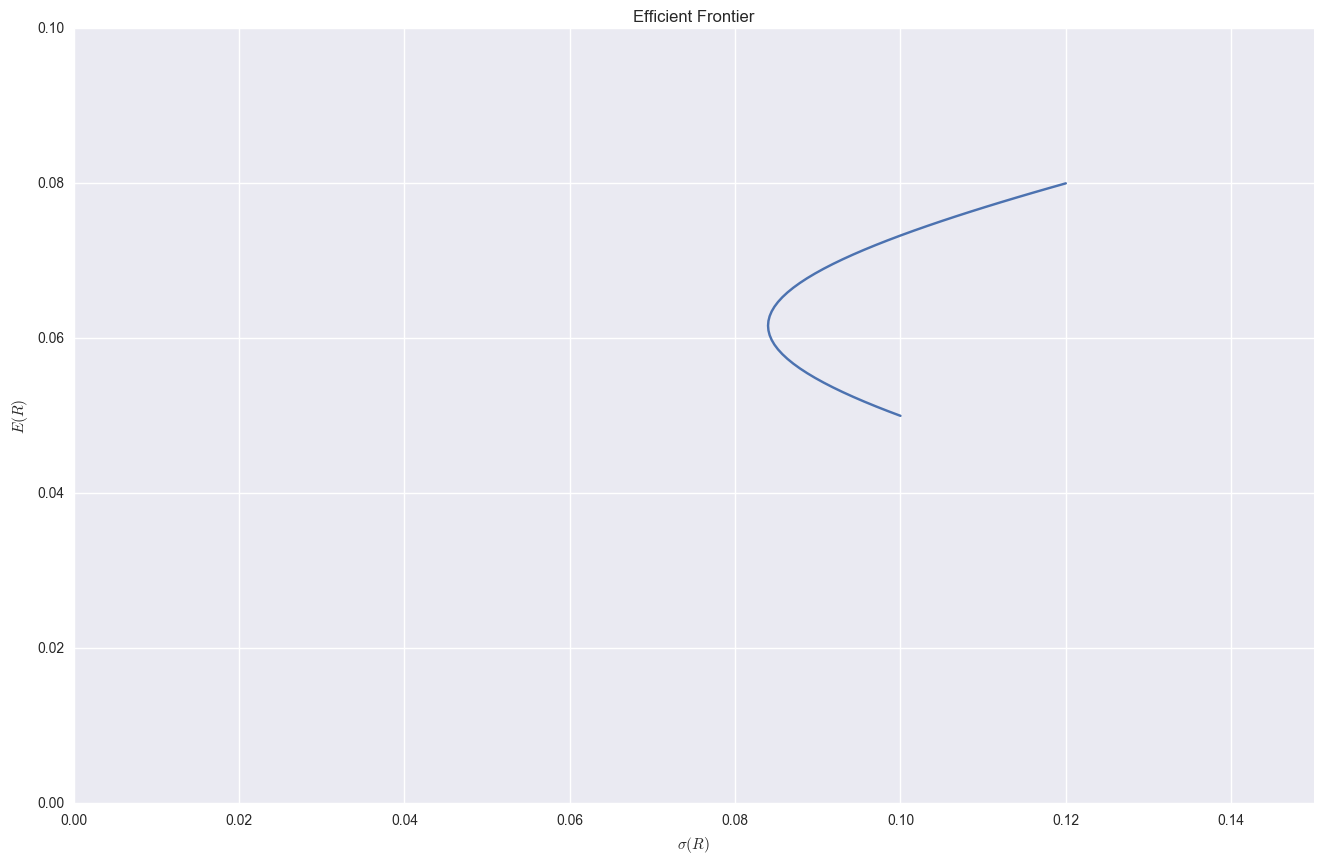

In [3]:
efficfront(dcml=0)

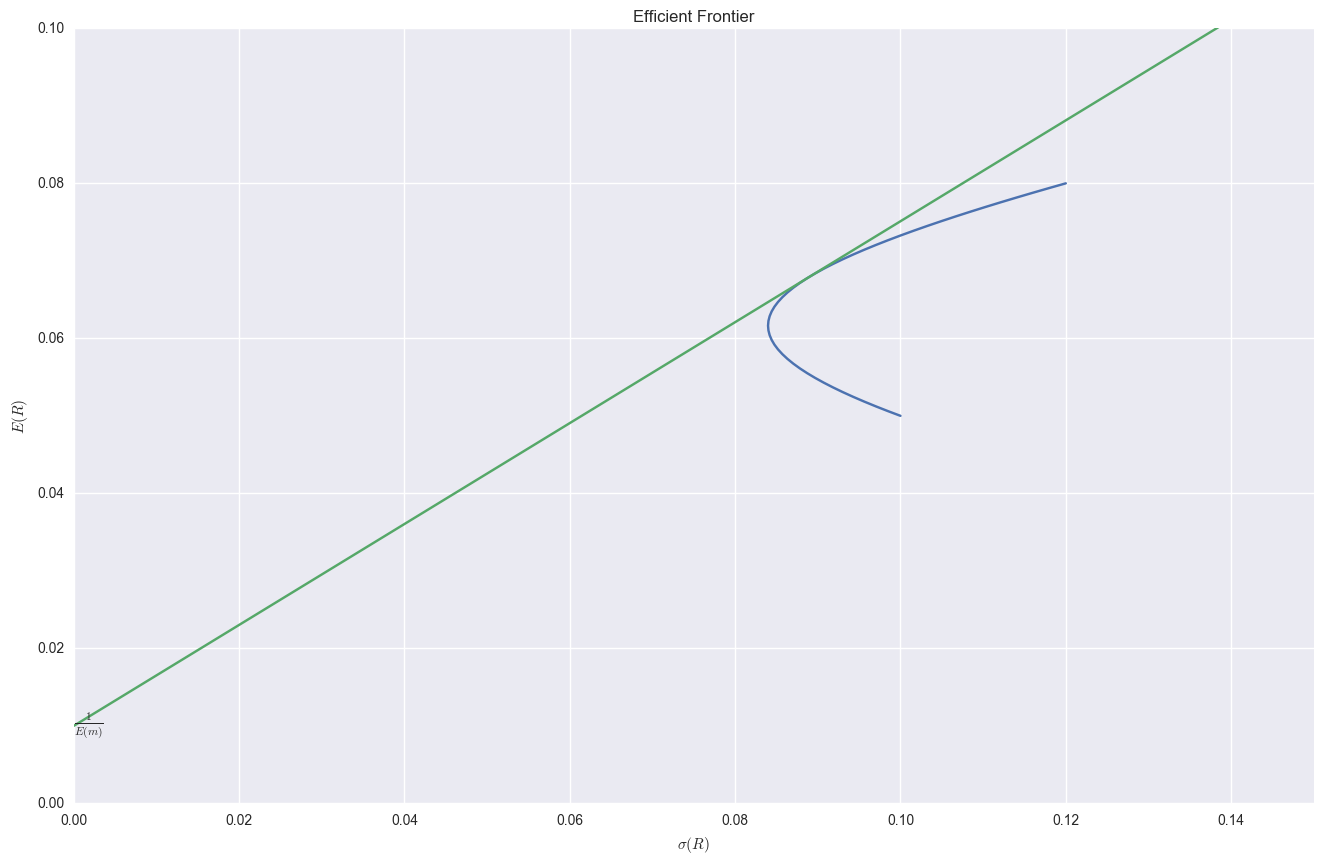

In [4]:
efficfront(dcml=1)

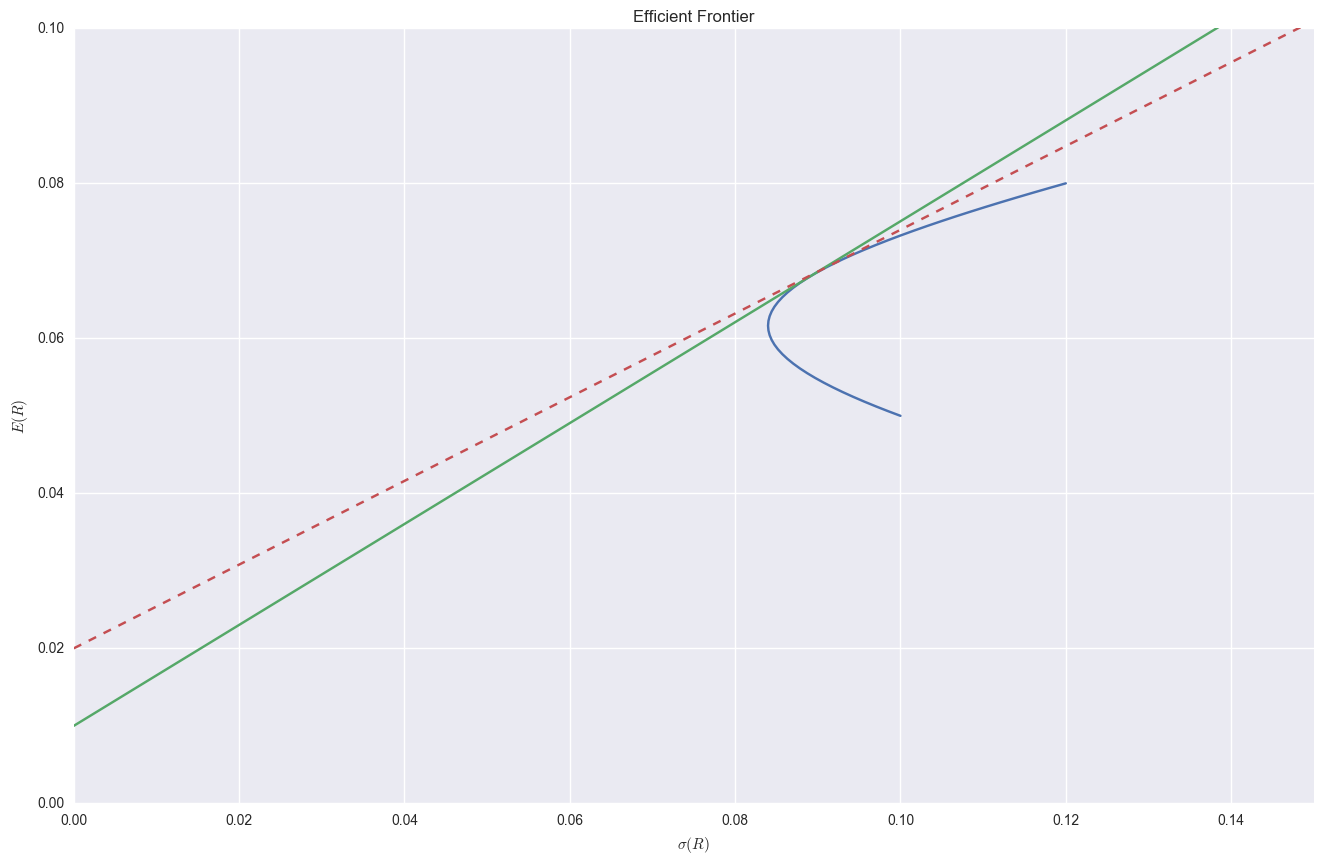

In [5]:
efficfront(dcml=2)

We can trace out volatility bounds with maximum Sharpe ratio. As $r_f$ increase, the maximum Sharpe ratio decrease, the volatility bound is lowered. We can trace out the volatility bound with max sharp ratio line. 

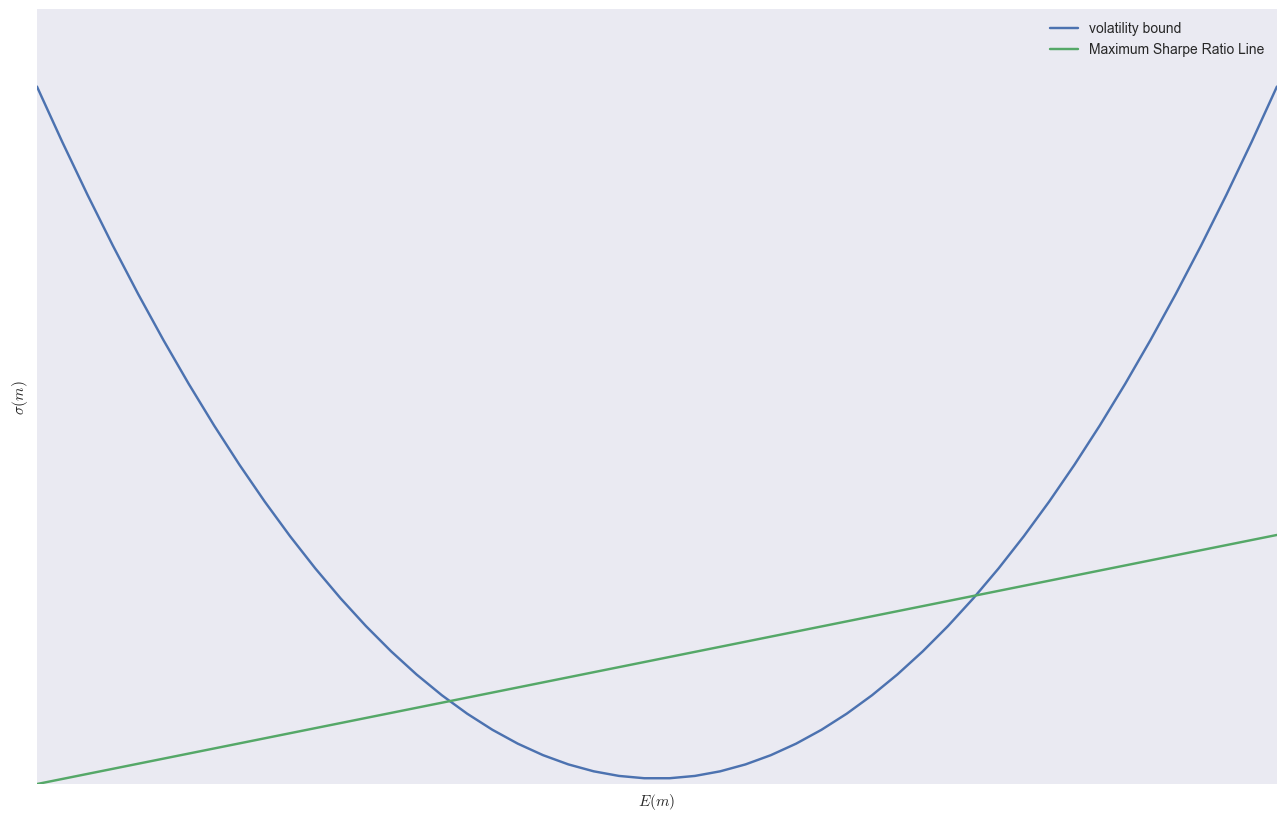

In [6]:
### The graphing here is just for illustraton purpose
### sigmam function is not be taken as is, in stead, sigmam fuction is traced out by E(m) on the max SR line
em =np.linspace(0,1,50)
maxsr = 0.45
sigmam = 0.01 + 5*(em-0.5)**2
fig, ax = plt.subplots()
plt.plot(em, sigmam, label='volatility bound')
plt.plot(em, maxsr*em, label='Maximum Sharpe Ratio Line')
plt.ylabel(r'$\sigma (m)$')
plt.xlabel(r'$E(m)$')
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()

#### Empirical measure of volatility bounds

Let's soppose we know that maximum possible Sharpe ratio is achieved by market portfolio, let's look at some numerical property of $m$.

$$m_{t+1}=  E_{t}[m_{t+1}] + \epsilon_{t+1} $$
$$ E(m)=E(\frac{1}{1+R^{f}_{t+1}}) $$
$$ VAR[E_{t}(m_{t+1})]=VAR(\frac{1}{1+R^{f}_{t+1}}) $$

In [7]:
# Get Some Real data
#You can get also annualized risk free data 
#from FRED  4-Week Treasury Bill: Secondary Market Rate (Series id TB4WK) 
#Below is directly use Fama-French data Libary 
df = pd.read_csv("../datalib/ff_factors.csv")
df['Date']=pd.to_datetime(df.dateff.astype('str'))
df = df.set_index('Date')
df = df[['mktrf', 'rf']]
#df = df['1927':'2014']
# Annualized returns
df['rfa']=df['rf']*12
df['mktreta'] = df['mktrf']*12
df.head(3)

,mktrf,rf,rfa,mktreta
Date,,,,
1926-07-31,0.0296,0.0022,0.0264,0.3552
1926-08-31,0.0264,0.0025,0.0300,0.3168
1926-09-30,0.0036,0.0023,0.0276,0.0432


In [8]:
df = df[df['rfa']>=0]  # keep only non-negative interest rate
invr = lambda x: 1/(1+x)
df['rf_inv']= df['rfa'].apply(invr)
df.head(3)

,mktrf,rf,rfa,mktreta,rf_inv
Date,,,,,
1926-07-31,0.0296,0.0022,0.0264,0.3552,0.974279
1926-08-31,0.0264,0.0025,0.0300,0.3168,0.970874
1926-09-30,0.0036,0.0023,0.0276,0.0432,0.973141


In [9]:
EM = df['rf_inv'].mean()
print('Mean SDF or E(m) =', EM)

Mean SDF or E(m) = 0.9677896955972642


In [10]:
VarEM = df['rf_inv'].var()
print('Variance of conditional expectation of SDF, Var(E(m))=', VarEM)

Variance of conditional expectation of SDF, Var(E(m))= 0.0007697046704228207


Variance of E(m) is very small, given current information, SDF doesn't vary much.

$$ \sigma_{m} \geq E(m) \frac{E(R_{M}-R_{f})}{\sigma_{R^{e}_{i}}} $$

In [11]:
#calculate sharpe ratio
Emkt = df['mktreta'].mean()
Stdmkt = df['mktreta'].std()
SR_exmkt = Emkt/Stdmkt
print('Market Excess Return Sharpe Ratio=', SR_exmkt)

Market Excess Return Sharpe Ratio= 0.14068990020151104


In [12]:
SigmaM = EM*SR_exmkt
print('sigma(m)>=', SigmaM)
print('Var[m] >=', SigmaM**2)

sigma(m)>= 0.13615823568962984
Var[m] >= 0.01853906514611279


$$ m_{t+1}=  E_{t}[m_{t+1}] + \epsilon_{t+1}$$ so
$$ VAR(m_{t+1})= VAR(E_{t}[m_{t+1}]) + VAR(\epsilon_{t+1}) $$
or 
$$ VAR(\epsilon_{t+1}) = VAR(m_{t+1}) - VAR(E_{t}[m_{t+1}]) $$

In [13]:
VarError = SigmaM**2 - VarEM
print('Variance of Error in predicting m =', VarError)
print('which is {:.2%} of total variance'.format(VarError/SigmaM**2))

Variance of Error in predicting m = 0.017769360475689968
which is 95.85% of total variance


* The conditional mean of the SDF is practically constant, but the SDF is very volatile.
* Almost none of the SDF volatility is predictable!

SDF view on Equity Premium Puzzle
* SDF is extremely volatile, no wonder consumption based models fail - consumption growth is very smooth
* This is a more general statement of the equity premium puzzle.

### Mean Variance

#### Mean Variance of Two Assets
Mean-variance of $(E R_{1},\sigma_{1}) $ and $(E R_{2},\sigma_{2})$ with investment share $\omega, (1-\omega)$:

$$ ER_{p}=\omega ER_{1} + (1-\omega) ER_{2}$$

$$\sigma_{p}=\sqrt{\omega^{2}\sigma^{2}_{1}+(1-\omega)^{2}\sigma^{2}_{2}+2\omega(1-\omega)\rho_{12}\sigma_{1}\sigma_{2}} $$
When $\rho\neq 1$, $\sigma_{p}<\omega\sigma_{1}+(1-\omega)\sigma_{2}$. There is gain from diversification.

In [14]:
er1 = 0.12
er2 = 0.08
s1 = 0.18
s2 = 0.16
#rho = 0.2
# to see how diversification benefit changes when rho change
# redefine rho, e.g., rho=-1, rho=1, etc.  


In [15]:
w = np.linspace(0,1, 50)
def mv2assets(rho=0.3):
    er_p =  w*er1+(1-w)*er2 # expected return
    sigma_p = np.sqrt(w**2*s1**2+(1-w)**2*s2**2+2*w*(1-w)*rho*s1*s2) # volatility
    zipped = pd.DataFrame(list(zip(er_p, sigma_p)), columns=['er_p', 'sigma_p'])
    return zipped

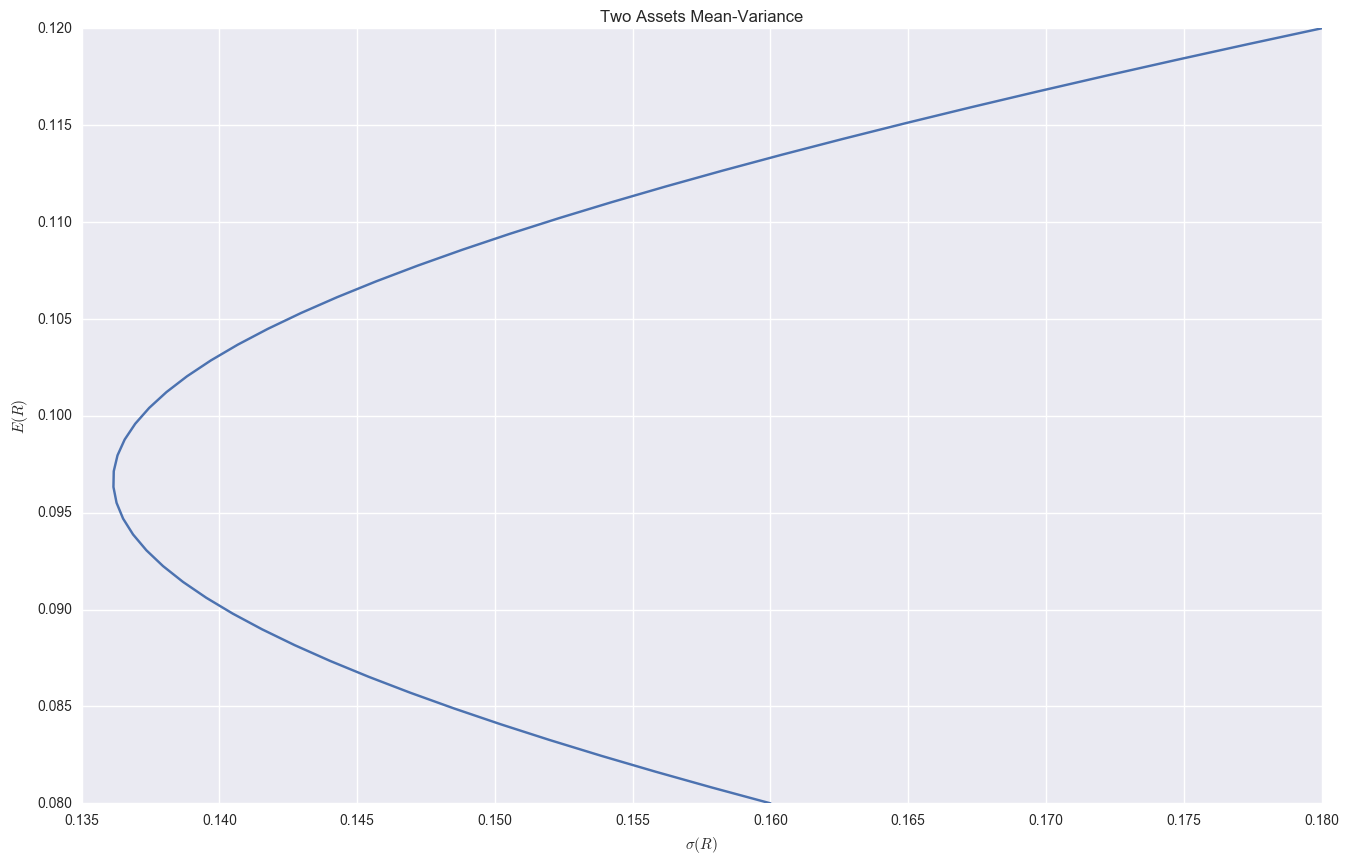

In [16]:
zipped = mv2assets(rho=0.3)
fig = plt.figure()
plt.plot(zipped['sigma_p'], zipped['er_p'])
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Two Assets Mean-Variance')
plt.show()

With only two risky assets and a risk free asset, one can choose ω to maximize Sharpe ratio.

Mamimum Sharpe Ratio is: 0.666646186675


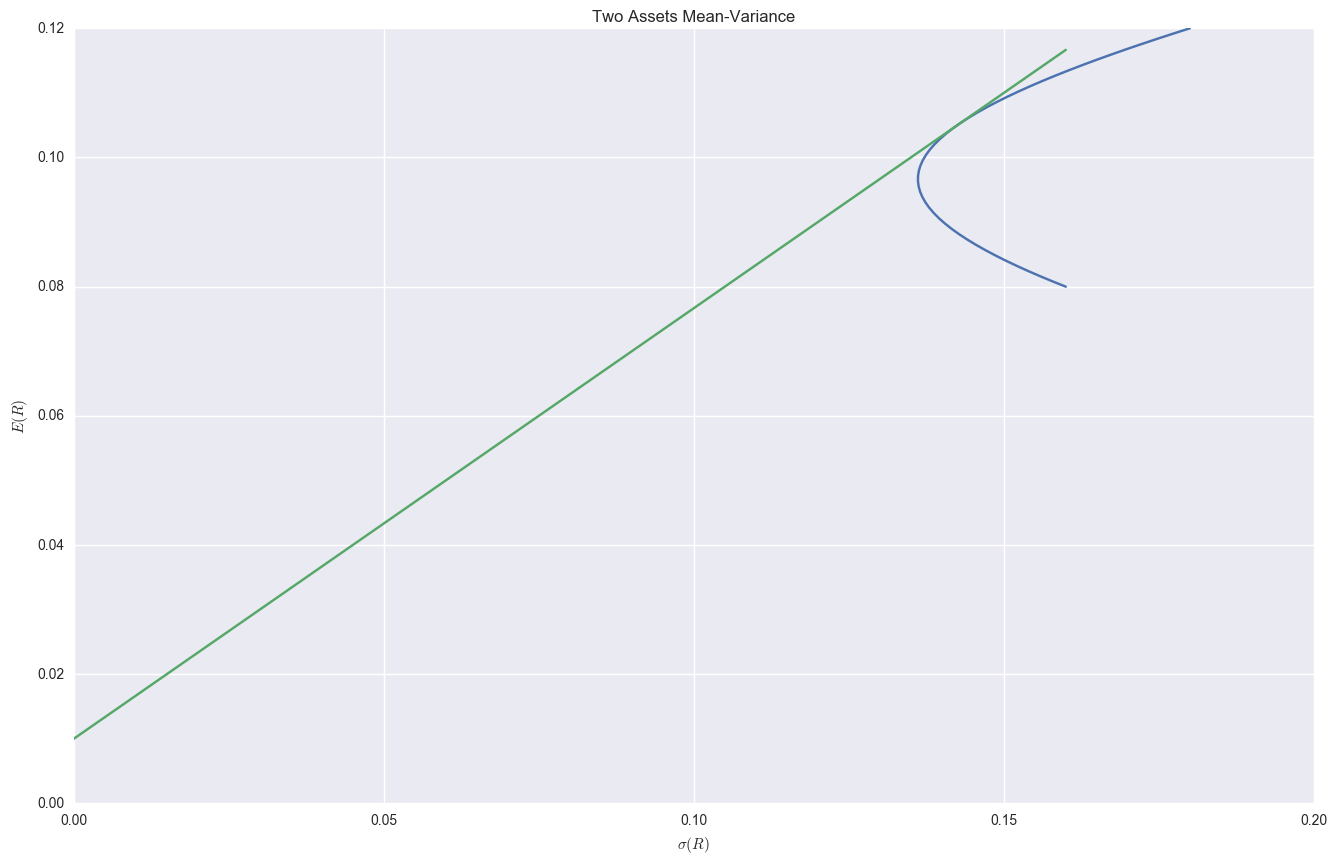

In [17]:
rf = 0.01
sr = (zipped['er_p']-rf)/zipped['sigma_p']
maxsr = sr.max()
print('Mamimum Sharpe Ratio is:', maxsr)
x = np.linspace(0,0.16, 50)
cml = rf + maxsr*x

fig = plt.figure()
plt.plot(zipped['sigma_p'], zipped['er_p'])
plt.plot(x, cml)
plt.xlim([0, 0.2])
plt.ylim([0, 0.12])
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Two Assets Mean-Variance')
plt.show()

There is a unique $\omega$ that solves maximum Sharpe ratio problem.

In [18]:
# Solve for w that maximize Sharpe ratio
func = lambda w: (w*er1+(1-w)*er2-rf)/np.sqrt(w**2*s1**2+(1-w)**2*s2**2+2*w*(1-w)*0.3*s1*s2) -maxsr
wstar = fsolve(func, 0.03)[0]  # 0.03 is the initial guess
print('ω that gives maximum SR:', wstar)

ω that gives maximum SR: 0.620608021569


Multiple Risky Assets
* With two assets, the mean return target uniquely defines the portfolio weights.
* This is no longer true when we have $N$ risky assets. Now the problem is to find the "minimum-variance frontier" of portfolios that have minimum variance for a given mean return.

### Minimum Variance Frontier
----------------------
#### Mean-Variance Without Risk Free Rate

Let $\omega$ be a vector of portfolio weight, R be a vector of asset returns, with mean vector $\bar R$, then the portfolio return is $\omega'R$ with mean return $\omega'\bar R$. The portfolio variance is
$$E[(\omega' R-\omega'\bar R)(\omega' R-\omega'\bar R)'] = \omega'E[(R-\bar{R})(R-\bar{R})']\omega$$

$$ \min_{\omega} \frac{1}{2}\omega' \Sigma \omega $$
$$\text{s.t. } \quad \omega'\bar{R}=\mu $$
$$ \omega'\iota=1 $$

* $\omega$ is portfolio weight
* $\bar{R}=E(R)$
* $\Sigma=E[(R-\bar{R})(R-\bar{R})']$
* $\iota=$a vector of 1s

$$\mathcal{L}=\frac{1}{2}\omega' \Sigma \omega-\lambda_{1}(\omega'\bar{R}-\mu)-\lambda_{2}(\omega'\iota-1)$$
FOC
$$ \Sigma \omega=\lambda_{1}\bar{R}+\lambda_{2}\iota $$
multiply both sides by $\Sigma^{-1}$
$$ \omega=\lambda_{1}\Sigma^{-1}\bar{R}+\lambda_{2}\Sigma^{-1}\iota $$
now consider the constraints
$$ \left\{\begin{aligned}
\mu &=\omega'\bar{R}=(\lambda_{1}\bar{R}'\Sigma^{-1}+\lambda_{2}\iota'\Sigma^{-1})\bar{R}=\lambda_{1}\bar{R}'\Sigma^{-1}\bar{R}+\lambda_{2}\iota'\Sigma^{-1}\bar{R}\\
1 &= \omega'\iota=\lambda_{1}\bar{R}'\Sigma^{-1}\iota+\lambda_{2}\iota'\Sigma^{-1}\iota
\end{aligned}\right.$$
Notice that $\Sigma^{-1}$ is symmetric, and $\iota'\Sigma^{-1}\bar{R}=\bar{R}'\Sigma^{-1}\iota$ is a scalar

We can two the above equation as
$$
 \begin{bmatrix}
  A & B \\
  B & C
 \end{bmatrix}
  \begin{bmatrix}
 \lambda_{1}\\
 \lambda_{2}
 \end{bmatrix}=  \begin{bmatrix}
 \mu\\
 1
 \end{bmatrix}
$$
where
$$\left\{\begin{aligned}
A &=\bar{R}'\Sigma^{-1}\bar{R}\\
B &=\bar{R}'\Sigma^{-1}\iota \\
C &=\iota'\Sigma^{-1}\iota
\end{aligned}\right.$$


##### solution <a name="mv_solution"></a>

$$\left\{\begin{aligned}
\lambda_{1} &=\frac{C\mu-B}{AC-B^{2}}\\
\lambda_{2} &=\frac{A-B\mu}{AC-B^{2}} \\
\omega & =\lambda_{1}\Sigma^{-1}\bar{R}+\lambda_{2}\Sigma^{-1}\iota
\end{aligned}\right.$$

##### Minimized Variance
$$ \hat{\sigma^{2}_{p}} =\omega' \Sigma \omega=\omega' \Sigma (\lambda_{1}\Sigma^{-1}\bar{R}+\lambda_{2}\Sigma^{-1}\iota) $$
$$= \lambda_{1}\omega'\bar{R}+ \lambda_{2}\omega'\iota=\lambda_{1}\mu + \lambda_{2} $$
$$ = \frac{C\mu^{2}-B\mu}{AC-B^{2}}+\frac{A-B\mu}{AC-B^{2}}$$
$$ = \frac{A-2B\mu +C\mu^{2}}{AC-B^{2}}$$

* 1/2$\frac{\partial \hat{\sigma^{2}_{p}}}{\partial \mu} = \lambda_{1} $, $\lambda_{1}$ measures the variance cost of a higher mean return target.
* For any give $\mu$, we can find $\omega$, then $(\hat{\sigma_{p}}, \mu)$, gives us points on the minimum variance frontier.

###### Linearity of $\omega$

$$ \omega  =\frac{C\mu-B}{AC-B^{2}}\Sigma^{-1}\bar{R}+\frac{A-B\mu}{AC-B^{2}} \Sigma^{-1}\iota $$

$\omega$ is a linear function of $\mu$, ($\omega=g+h\mu$). If $\mu_{q}=\alpha\mu_{1}+(1-\alpha)\mu_{2}$, then $\omega_{q}=\alpha\omega_{1}+(1-\alpha)\omega_{2}$ also satisfies [solution](#mv_solution).

##### Spanning
The linear property of $\omega$ gives us spanning 
* You can span the mean-variance frontier using any two portfolios on the frontier. Any linear combination of portfolios on frontier is also on frontier.

##### Example
Apple, IBM, Microsoft, Nike, Disney
14593, 12490, 10107, 57665, 26403

In [2]:
permnolist = [14593, 12490, 10107, 57665, 26403]
msf = pd.read_csv('../datalib/msf92.csv')
msf['date']=pd.to_datetime(msf.date)
msf = msf.set_index('date')
msf['PERMNO'] = msf['PERMNO'].astype('int')
msf = msf[msf.PERMNO.isin(permnolist)]
msf = msf['1994':'2004']
msf.head()

,PERMNO,RET
date,,
1994-01-31,10107,0.055814
1994-02-28,10107,-0.030837
1994-03-31,10107,0.027273
1994-04-29,10107,0.091445
1994-05-31,10107,0.162162


In [3]:
rbar = msf.groupby('PERMNO').mean()
rbar

,RET
PERMNO,
10107,0.025112
12490,0.019864
14593,0.024089
26403,0.009195
57665,0.021806


In [4]:

cov = msf.reset_index().set_index(['PERMNO', 'date']).unstack('PERMNO').cov()
cov

RET                                        
PERMNO         10107     12490     14593     26403     57665
    PERMNO                                                  
RET 10107   0.012708  0.005858  0.005591  0.002000  0.001285
    12490   0.005858  0.009075  0.005470  0.002915  0.001178
    14593   0.005591  0.005470  0.024300  0.002089 -0.000288
    26403   0.002000  0.002915  0.002089  0.006835  0.001655
    57665   0.001285  0.001178 -0.000288  0.001655  0.010272

In [5]:
# convert from pandas to np array then to matrix 
rbar = rbar.as_matrix()
rbar = np.matrix(rbar)
cov = cov.as_matrix()
cov = np.matrix(cov)
rbar, cov

(matrix([[ 0.02511189],
         [ 0.01986403],
         [ 0.02408865],
         [ 0.00919527],
         [ 0.02180563]]),
 matrix([[ 0.01270789,  0.00585775,  0.00559143,  0.00200037,  0.00128527],
         [ 0.00585775,  0.00907483,  0.0054695 ,  0.00291537,  0.00117826],
         [ 0.00559143,  0.0054695 ,  0.02430009,  0.00208913, -0.00028811],
         [ 0.00200037,  0.00291537,  0.00208913,  0.00683457,  0.00165468],
         [ 0.00128527,  0.00117826, -0.00028811,  0.00165468,  0.01027156]]))

Given $\bar R, \Sigma$, for each $\mu$ we can use our [derived formula](#mv_solution) to calculate $\omega$ and $\hat{\sigma^{2}}_{p}$

In [6]:
def meanvar(mu, rbar=rbar, cov=cov):
    ones = np.ones(rbar.shape)
    A = rbar.T.dot(inv(cov)).dot(rbar)[0,0]
    B = rbar.T.dot(inv(cov)).dot(ones)[0,0]
    C = ones.T.dot(inv(cov)).dot(ones)[0,0]
    omega = (C*mu-B)/(A*C-B**2)*dot(inv(cov), rbar) + (A-B*mu)/(A*C-B**2)*dot(inv(cov), ones)
    varhut = np.sqrt(omega.transpose().dot(cov).dot(omega))[0,0]
    return omega, varhut

In [7]:
print('Weight Vector of required rate of return=0.02:', meanvar(0.02)[0])
print('Portfolio return standard deviation is: {:.3f}'.format(meanvar(0.02)[1]))

Weight Vector of required rate of return=0.02: [[ 0.18760071]
 [ 0.17386046]
 [ 0.09781739]
 [ 0.18331272]
 [ 0.35740872]]
Portfolio return standard deviation is: 0.065


Plotting required expected return $\mu$ against minimized variance $\sigma_{p}$. 

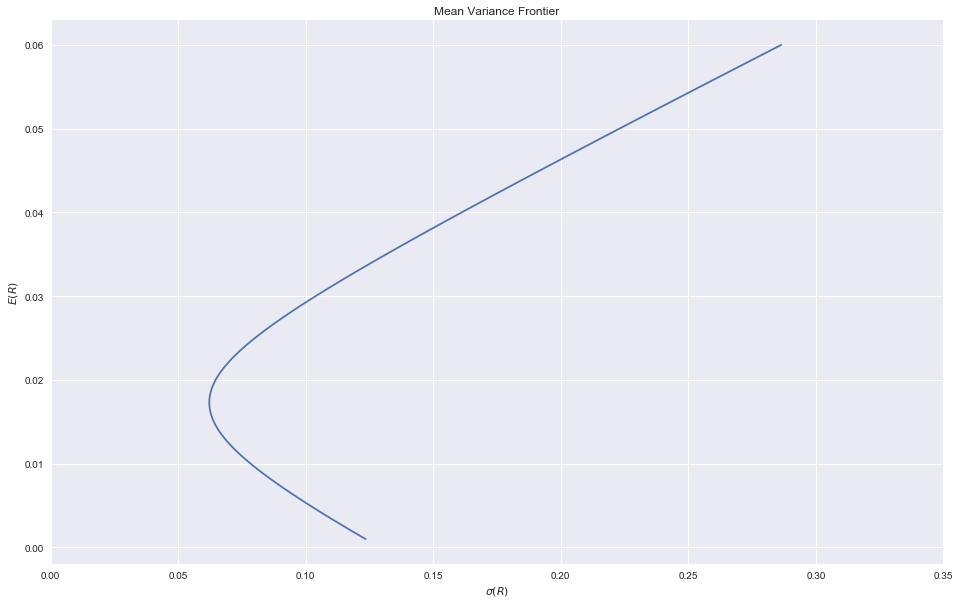

In [77]:
mus = np.linspace(0.001, 0.06, 100)
sigmas =[]
for m in mus:
    sm = meanvar(m)[1]
    sigmas.append(sm)
zipped =zip(mus, sigmas)

fig, ax = plt.subplots()
plt.plot(sigmas, mus, label='Mean Variance Frontier')
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Mean Variance Frontier')
plt.xlim([0, 0.35])
plt.show()

##### Global Minimum Variance portfolio

Drop mean return constraint, i.e. set $\lambda_{1}=0$. We get
$$ \left. \begin{aligned}
\omega_{G} &=\lambda_{2}\Sigma^{-1}\iota  \\
 1&= \omega_{G}'\iota
\end{aligned}\right\} \Rightarrow \lambda_{2}=\frac{1}{C}, \quad \omega_{G}=\frac{\Sigma^{-1}\iota}{C} $$

$$\omega_{G}'\bar{R}=\frac{\iota'\Sigma^{-1}\bar{R}}{C}=\frac{B}{C}$$

$$ \sigma^{2}_{p, G}=\omega_{G}'\Sigma\omega_{G}=\frac{\iota'\Sigma^{-1}\Sigma\Sigma^{-1}\iota}{(\iota'\Sigma^{-1}\iota)^{2}}=\frac{1}{C} $$

In [78]:
import math
ones = np.ones(rbar.shape)
GMVstd = math.sqrt(1/ones.T.dot(inv(cov)).dot(ones)[0,0])
GMVret = rbar.T.dot(inv(cov)).dot(ones)[0,0]/ones.T.dot(inv(cov)).dot(ones)[0,0]
print('Global Minimum Std:{:.3f}; Expected Return for Golobal Minimum Variance Portfolio:{:.3f}'.format(GMVstd, GMVret))

Global Minimum Std:0.062; Expected Return for Golobal Minimum Variance Portfolio:0.017


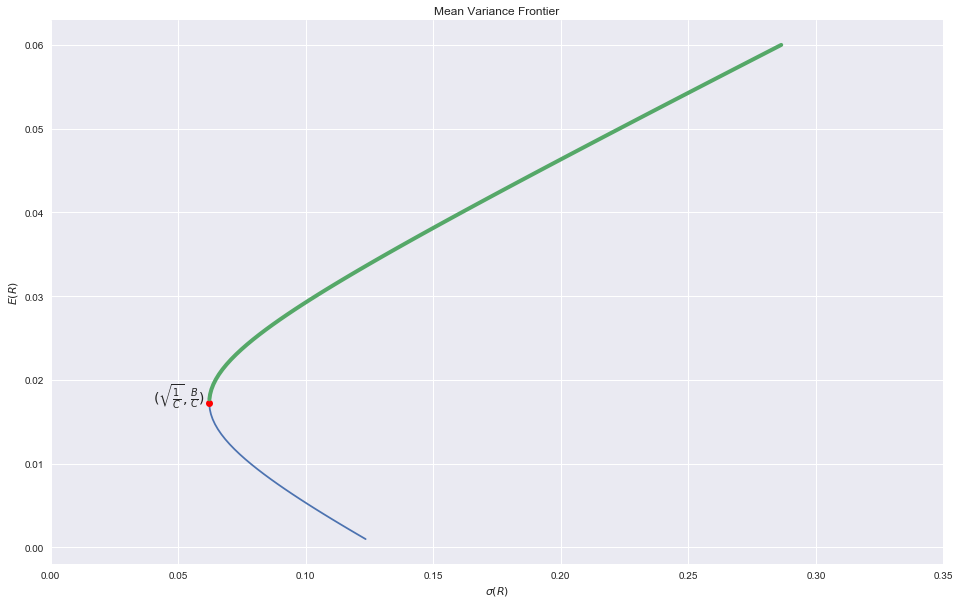

In [79]:
ef=pd.DataFrame(list(zipped)) # python 3: use list of the zip, no need if python 2
ef.columns=['er', 'std']
ef = ef[ef.er>GMVret]

fig, ax = plt.subplots()
plt.plot(sigmas, mus, label='Mean Variance Frontier')
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Mean Variance Frontier')
plt.xlim([0, 0.35])
ax.text(GMVstd-0.022, GMVret, r'$(\sqrt{\frac{1}{C}}, \frac{B}{C})$', fontsize=14)
ax.plot(GMVstd, GMVret, 'or')
plt.plot(ef['std'], ef['er'], linewidth=4)
plt.show()

##### Efficient Frontier

* With mean return constraint, $\mu> \frac{B}{C}$ ($\lambda_{1}>0 $).
* The set of minimum-variance portfolios that satisfy this condition is called the mean-variance efficient. 

#### Mean-Variance With Risk Free Asset

With an risk-free asset, we can lend or borrow at $R_{f}$.  Rewrite the problem as choosing weights $\omega$ of wealth in the **risky assets**. Thus we no longer require $\omega'\iota=1$.

$$ \min_{\omega} \frac{1}{2}\omega' \Sigma \omega \qquad
\text{s.t. }  \omega'(\bar{R}-R_{f}\iota)=\mu-R_{f} $$


Solving FOC we get $$\omega =\lambda \Sigma^{-1}(\bar{R}-R_{f}\iota) $$
$$\lambda =\frac{\mu-R_{f}}{(\bar{R}-R_{f}\iota)'\Sigma^{-1}(\bar{R}-R_{f}\iota)} $$

$$\hat{\sigma^{2}_{p}}=\omega' \Sigma \omega=\frac{(\mu-R_{f})^{2}}{(\bar{R}-R_{f}\iota)'\Sigma^{-1}(\bar{R}-R_{f}\iota)}$$

Notice that $$\left|\frac{E(R_{p})-R_{f}}{\hat{\sigma_{p}}}\right|=\sqrt{(\bar{R}-R_{f}\iota)'\Sigma^{-1}(\bar{R}-R_{f}\iota)}$$ is the Sharpe ratio of the tangency portfolio.
 * With $R_{f}$, any optimal portfolio is a combination of tangency portfolio and risk-free asset, depending on risk aversion.

In [80]:
def meanvar_rf(rf, mu, rbar=rbar, cov=cov):
    ones = np.ones(rbar.shape)
    lamda = (mu-rf)/(rbar-rf*ones).T.dot(inv(cov)).dot(rbar-rf*ones)[0,0]
    omegarf = lamda*inv(cov).dot(rbar-rf*ones)
    varhutrf = np.sqrt((mu-rf)**2 /(rbar-rf*ones).T.dot(inv(cov)).dot(rbar-rf*ones))[0,0]
    return omegarf, varhutrf

In [81]:
# rf = 0.01 and mu =0.03
# returns weight and minimized std

meanvar_rf(0.01, 0.03)

(matrix([[ 0.45181219],
         [ 0.25820274],
         [ 0.20257151],
         [-0.51861156],
         [ 0.62292681]]), 0.10385632209879966)

In [82]:
w0=meanvar_rf(0.01, 0.02)[0]
w0

matrix([[ 0.22590609],
        [ 0.12910137],
        [ 0.10128575],
        [-0.25930578],
        [ 0.3114634 ]])

In [83]:
w1=w0/w0.sum()
w1

matrix([[ 0.44430273],
        [ 0.25391121],
        [ 0.19920462],
        [-0.50999185],
        [ 0.61257329]])

relative weight within risky portfolio remains constent for different $\mu$. That's called *tangency portfolio*.

In [84]:
w0=meanvar_rf(0.01, 0.04)[0]
w1=w0/w0.sum()
w1

matrix([[ 0.44430273],
        [ 0.25391121],
        [ 0.19920462],
        [-0.50999185],
        [ 0.61257329]])

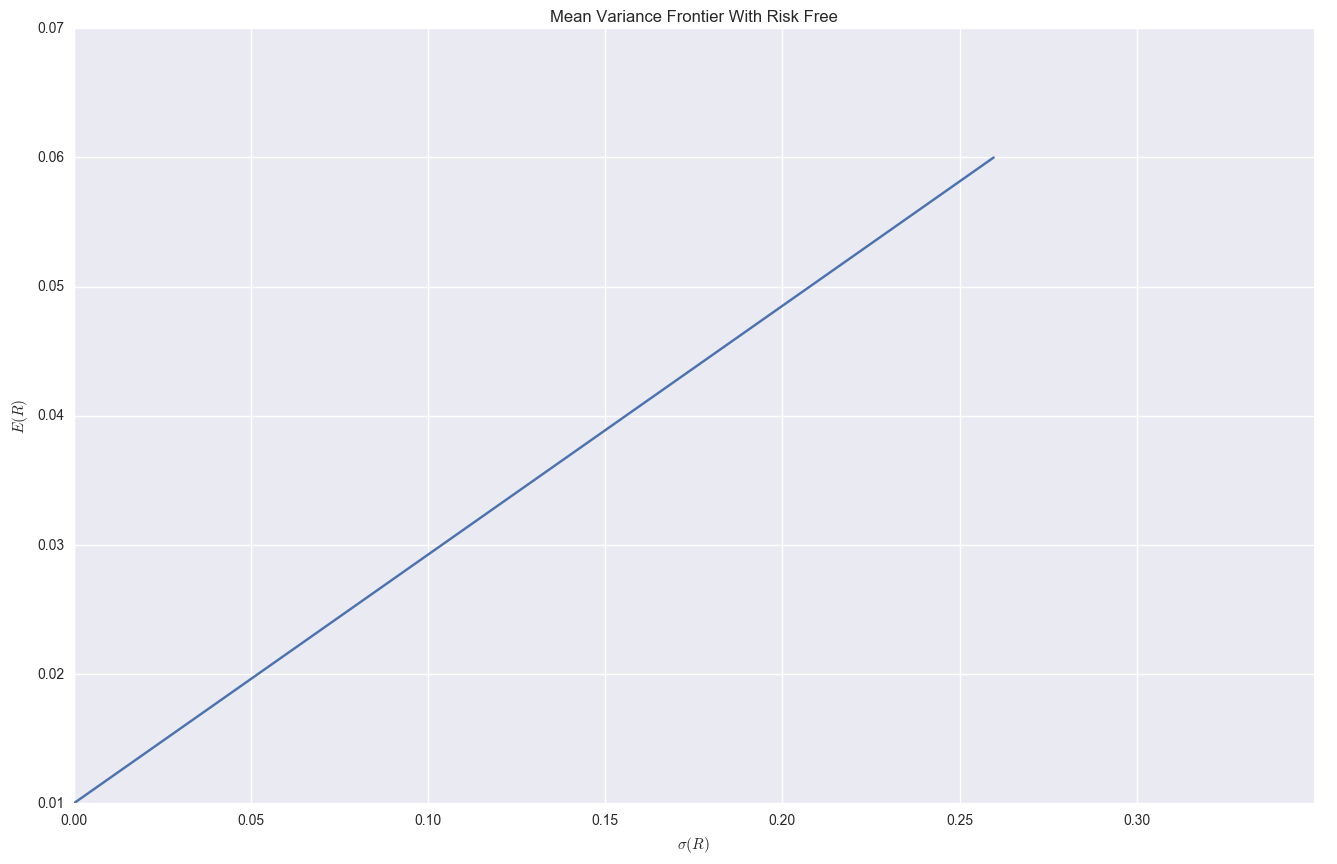

In [32]:
rf0=0.01
mus2 = np.linspace(0.01, 0.06, 100)
sigmas2 =[]
for m in mus2:
    sm = meanvar_rf(rf0, m)[1]
    sigmas2.append(sm)

fig, ax = plt.subplots()
plt.plot(sigmas2, mus2, label='Mean Variance Frontier')
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Mean Variance Frontier With Risk Free')
plt.xlim([0, 0.35])
plt.show()

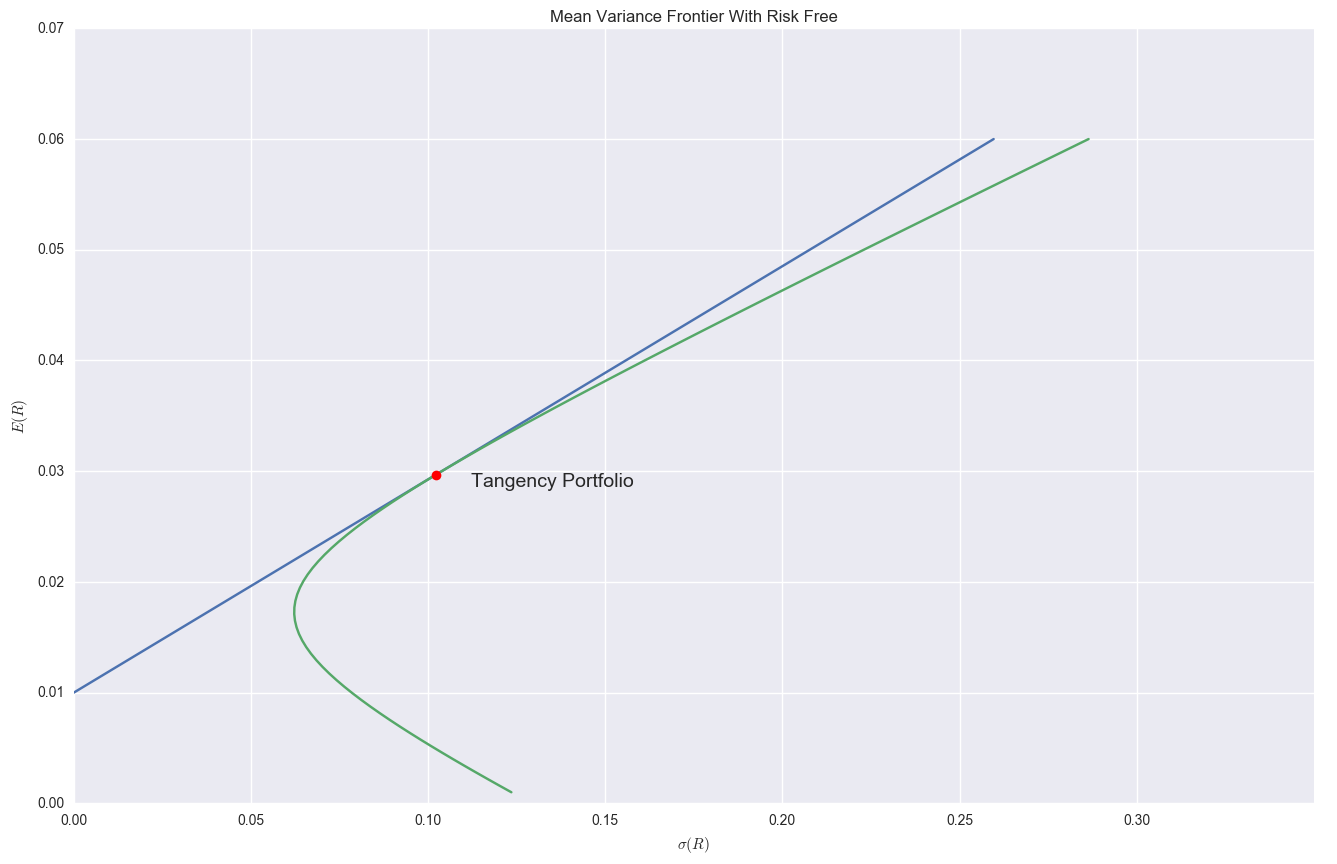

In [33]:
rf0=0.01
rmret = w1.T.dot(rbar)[0,0]
rstd =np.sqrt(w1.T.dot(cov).dot(w1))[0,0]
mus2 = np.linspace(0.01, 0.06, 100)
sigmas2 =[]
for m in mus2:
    sm = meanvar_rf(rf0, m)[1]
    sigmas2.append(sm)
zipped =zip(mus2, sigmas2)

fig, ax = plt.subplots()
plt.plot(sigmas2, mus2, label='Mean Variance Frontier')
plt.plot(sigmas, mus)
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Mean Variance Frontier With Risk Free')
plt.xlim([0, 0.35])
ax.plot(rstd, rmret, 'or')
ax.text(rstd+0.01, rmret-0.001, 'Tangency Portfolio', fontsize=14)
plt.show()

##### Do People Follow Two-Fund Theorem?

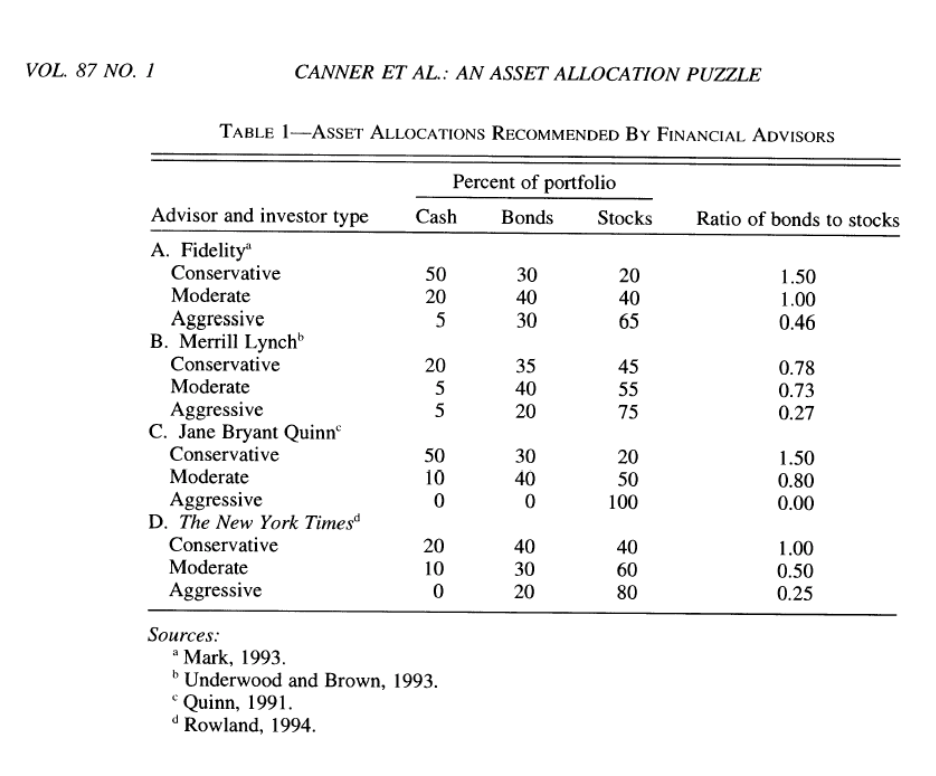

In [34]:
Image(filename='../img/Canner.png')

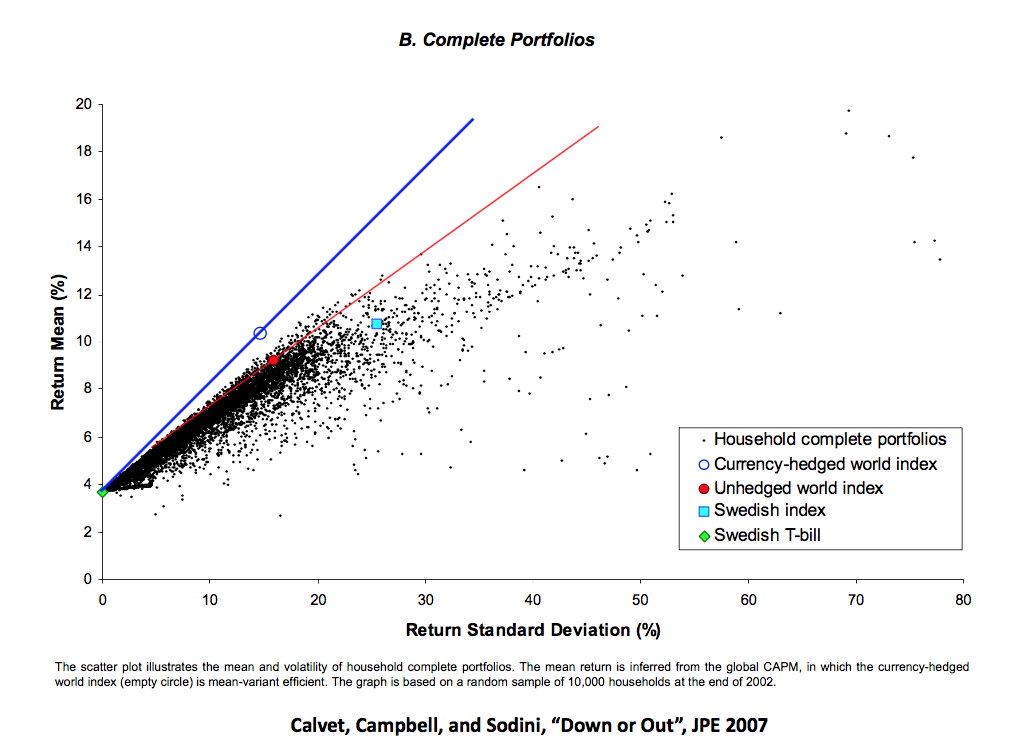

In [35]:
Image(filename='../img/Calvet1.png')

#### Problems in Practice

* Estimating means
  - Estimates imprecise over short periods
  - But means may not be constant over long periods
* Estimating variance-covariance matrix $\Sigma$
  - $\frac{N(N+1)}{2}$ elements to be estimated. Too many assets problem.
  - historical variance-covariance matrix may be singular, especially for many assets over short periods. This means that it cannot be inverted.
  - Some combinations of risky assets are almost riskless in data. This can lead to a highly leveraged portfolio.

### Extras: 
##### Mean-Variance with Non-negative Constraint

Solution to Mean-variance problem often involves negative weights, i.e., shorting of some assets. If shorting is not available (or not willing to undertake), then we need additional set of constraints such that $$\omega_{i}>=0 \quad \forall i\in N$$
In matrix notation, if we combine these constraint with the return constraint, then we should have constraint $$A\omega \geq b$$ where 

$$ A = 
\left[
\begin{array}{ccccc}
\bar R_{1}  & \bar R_{2} & \cdots & \bar R_{i} \\
1 & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 1%
\end{array}%
\right]
$$

and $$b=  \begin{pmatrix}\mu  & 0 &\cdots & 0 \end{pmatrix}^{T}  $$

This is usually unsolvable by hand. Here, we will use a quadratic program maximizer to demo the solution. 

The first step is to verify that our numarical solution under mu=0.03 is the same as our analytical solution before. 

In [ ]:
import cvxopt
from cvxopt import matrix, solvers
#Let's first verify that the numarical solution under mu=0.02 is the same as our analytical solution before  

# solves the QP, where x is the allocation of the portfolio:
# minimize   x'Px + q'x
# subject to Gx <= h
#            Ax == b
#
# Input:  n = rbar.shape[0]  - # of assets
#         rbar - nx1 matrix of average returns
#         covs    - nxn matrix of return covariance
#         mu   - the minimum expected return that you'd
#                   like to achieve
# Output: sol - cvxopt solution object
# Note cvxopt has it's own matrix representation.

In [65]:
mu =0.03
rf=0.01
n = rbar.shape[0]
P = matrix(cov)
q = matrix(np.zeros(n).reshape(n,1))
G = matrix(-np.array(rbar-rf).T)
h = matrix(-np.ones(1).reshape(1,1)*(mu-rf))

sol = solvers.qp(P, q, G, h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  6.8960e-06  3.7880e-04  2e-02  1e+00  8e-20
 1:  7.4269e-06  3.9284e-04  2e-04  3e-02  8e-20
 2:  9.6847e-05  1.3486e-03  7e-06  2e-02  3e-19
 3:  7.5853e-03  5.2066e-03  2e-03  1e-18  2e-17
 4:  5.4648e-03  5.3928e-03  7e-05  3e-19  4e-18
 5:  5.3938e-03  5.3931e-03  7e-07  2e-18  5e-18
 6:  5.3931e-03  5.3931e-03  7e-09  1e-18  5e-18
Optimal solution found.
[ 4.52e-01]
[ 2.58e-01]
[ 2.03e-01]
[-5.19e-01]
[ 6.23e-01]



Now, with the non-negative constraints. Notice that the weight on Macy's become virtually zero (instead of negative), and weights on all other stocks all changes (not just equally increase). 

In [72]:
# Now with additional constraint for w, combine then with constraint on mu

mu =0.02
n = rbar.shape[0]
P = matrix(cov)
q = matrix(np.zeros(n).reshape(n,1))
G = matrix(-np.concatenate(((rbar-rf).T, np.identity(n)), 0))
h = matrix(-np.concatenate((np.ones(1).reshape(1,1)*(mu-rf), np.zeros(n).reshape(n,1)), 0))
#A = matrix(1.0, (1,n))
#b = matrix(1.0)
sol = solvers.qp(P, q, G, h)
print('optimal weights under non-negative constraints:\n', sol['x'])

     pcost       dcost       gap    pres   dres
 0:  7.6398e-10  9.6075e-03  6e+00  2e+00  2e+00
 1:  5.6077e-02 -8.0976e-02  1e-01  2e-02  2e-02
 2:  1.2446e-02 -8.1331e-03  2e-02  3e-16  7e-18
 3:  2.7368e-03  1.5031e-04  3e-03  1e-16  5e-18
 4:  1.6510e-03  1.4492e-03  2e-04  3e-17  1e-18
 5:  1.5755e-03  1.5650e-03  1e-05  4e-17  7e-17
 6:  1.5729e-03  1.5726e-03  3e-07  2e-17  1e-16
 7:  1.5729e-03  1.5729e-03  3e-09  6e-17  5e-16
Optimal solution found.
optimal weights under non-negative constraints:
 [ 2.63e-01]
[ 6.26e-02]
[ 1.12e-01]
[ 1.33e-07]
[ 3.25e-01]



Now let's see put this into a function and see how frontier changes. 

In [73]:
def solveqp(mu, noneg=True, cov=cov, rbar=rbar):
    n = rbar.shape[0]
    P = matrix(cov)
    if noneg == True:
        q = matrix(np.zeros(n).reshape(n,1))
        G = matrix(-np.concatenate((rbar.T, np.identity(n)), 0))
        h = matrix(-np.concatenate((np.ones(1).reshape(1,1)*mu, np.zeros(n).reshape(n,1)), 0))
        A = matrix(1.0, (1,n))
        b = matrix(1.0)
        cvxopt.solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)['x']
        return np.sqrt(dot(sol.T, cov.dot(sol)))[0,0]
    else:
        q = matrix(np.zeros(n).reshape(n,1))
        G = matrix(-np.array(rbar).T)
        h = matrix(-np.ones(1).reshape(1,1)*mu)
        A = matrix(1.0, (1,n))
        b = matrix(1.0)
        cvxopt.solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)['x']
        return np.sqrt(dot(sol.T, cov.dot(sol)))[0,0]

In [74]:
mus =  np.linspace(0.013, 0.026, 30).tolist()
minstd = [solveqp(mu, noneg=False) for mu in mus ]
minstd2 = [solveqp(mu, noneg=True) for mu in mus ]

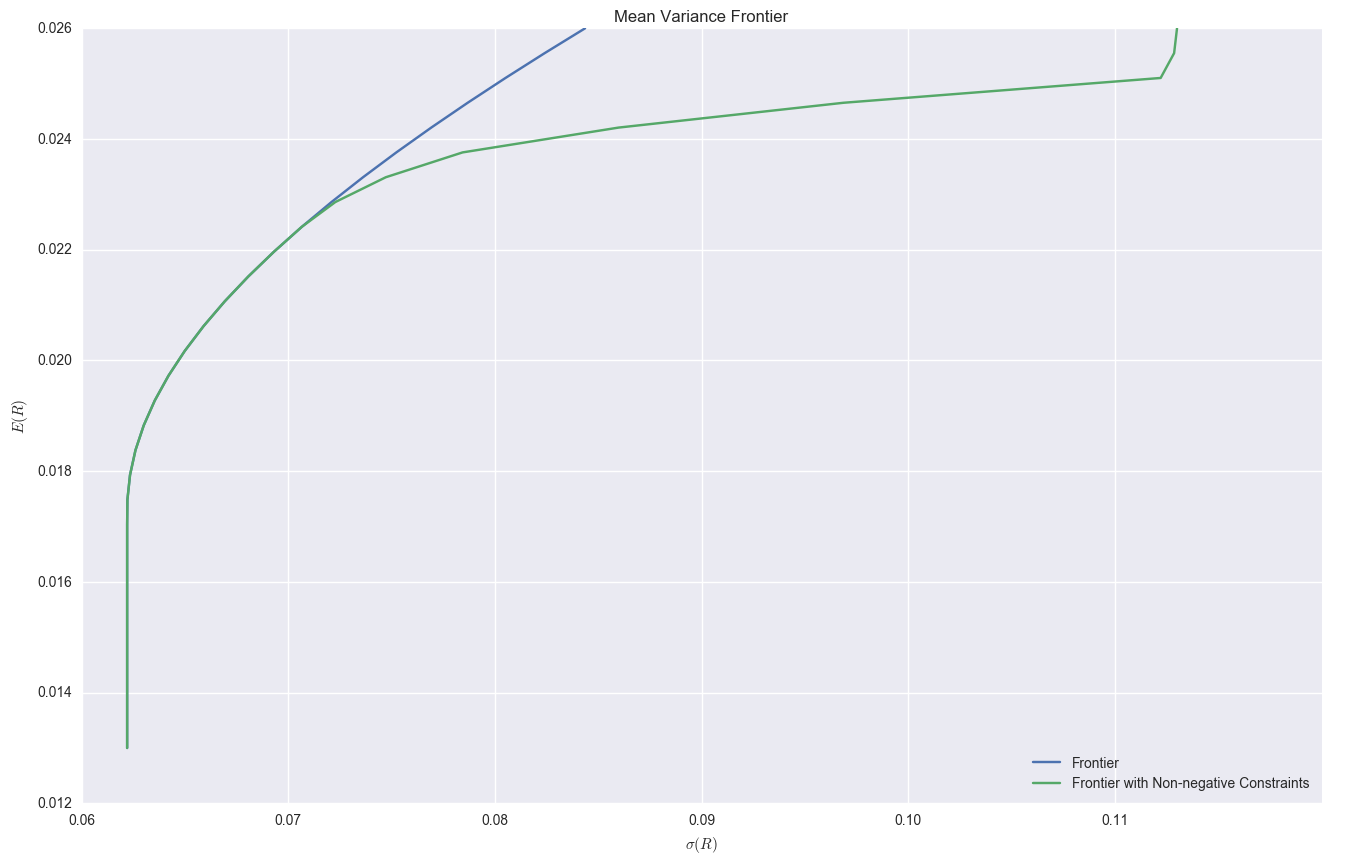

In [77]:
zipmin = pd.DataFrame(list(zip(minstd, minstd2, mus)))
zipmin.columns = ['std','std_noneg',  'mu']
fig, ax = plt.subplots()
plt.plot(zipmin['std'], zipmin['mu'],  label='Frontier')
plt.plot(zipmin['std_noneg'], zipmin['mu'],  label='Frontier with Non-negative Constraints')
plt.xlabel(r'$\sigma (R)$')
plt.ylabel(r'$E(R)$')
plt.title('Mean Variance Frontier')
plt.legend(loc='lower right')
plt.show()

With additional constraint, the new frontier is inside the original mean-variance efficient frontier. 

##### Back-Testing

Estimate the performance of a strategy, such as mean-variance, if it had been employed during a past period. You typically leave some periods out to obtain initial estimation (e.g., $\bar R, \Sigma$) then track the performance of your strategy along the investment horizon, rebalancing after each investment period. 